This is my easy ready reckoner on Linear Regression

In [1]:
library(funModeling)
library(car)
library(het.test)
library(lmtest)
library(caret)
library(gvlma)
#Loading all the packages

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

funModeling v.1.5 :)
Documentation at livebook.datascienceheroes.com

Loading required package: vars
Loading required package: MASS
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: urca
Loading required package: lmtest

Attaching package: ‘caret’

The following object is masked from ‘package:survival’:

    cluster



In [2]:
#Load the data
mydata <- read.csv("~/Downloads/airfoil_self_noise_reg_problem.csv")

In [3]:
#check the data
str(mydata)


'data.frame':	1503 obs. of  6 variables:
 $ Frquency.Hz.        : int  800 1000 1250 1600 2000 2500 3150 4000 5000 6300 ...
 $ Angle_of_Attack     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Chord_Length        : num  0.305 0.305 0.305 0.305 0.305 ...
 $ Free_stream_velocity: num  71.3 71.3 71.3 71.3 71.3 71.3 71.3 71.3 71.3 71.3 ...
 $ Displacement        : num  0.00266 0.00266 0.00266 0.00266 0.00266 ...
 $ Sound_pressure_level: num  126 125 126 128 127 ...


In [4]:
#Here , sound pressure level is to be predicted
df_status(mydata)

              variable q_zeros p_zeros q_na p_na q_inf p_inf    type unique
1         Frquency.Hz.       0    0.00    0    0     0     0 integer     21
2      Angle_of_Attack     329   21.89    0    0     0     0 numeric     27
3         Chord_Length       0    0.00    0    0     0     0 numeric      6
4 Free_stream_velocity       0    0.00    0    0     0     0 numeric      4
5         Displacement       0    0.00    0    0     0     0 numeric    105
6 Sound_pressure_level       0    0.00    0    0     0     0 numeric   1456


We do not have any missing data in any of the variables. We do have 0s in Angle of attack, but I suspect this is because of the fact that 0 can be an Angle of Attack. Hence no data imputation is necessary here.

Let us take a quick look at the data by plotting the data


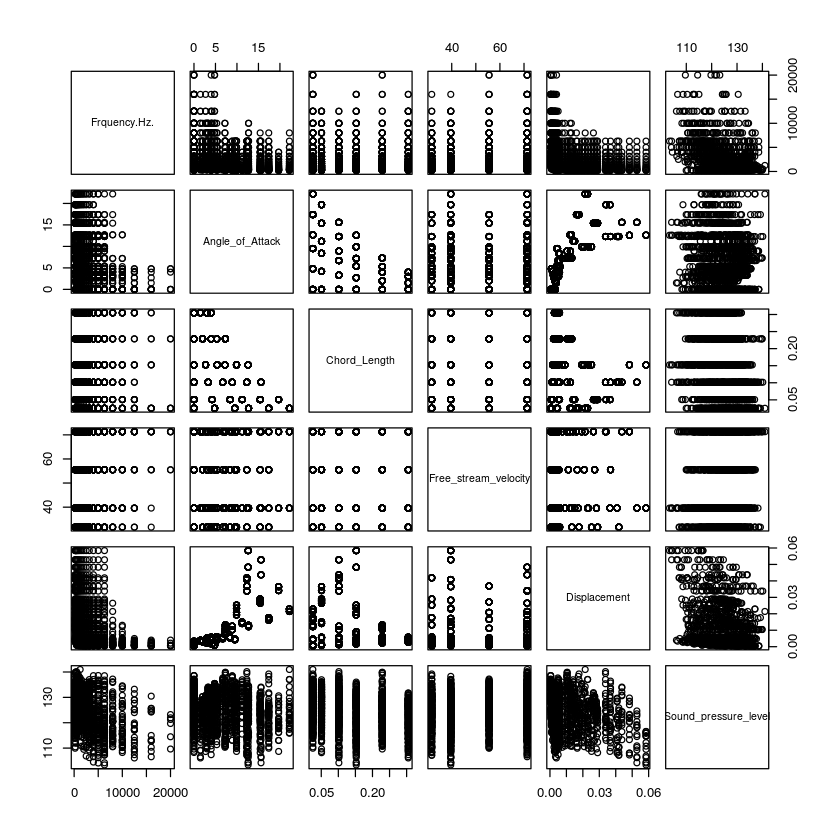

In [5]:
plot(mydata)

Can see some relationship between Displacement and Angle of Attack.

Now let's take a look at Corelation. 

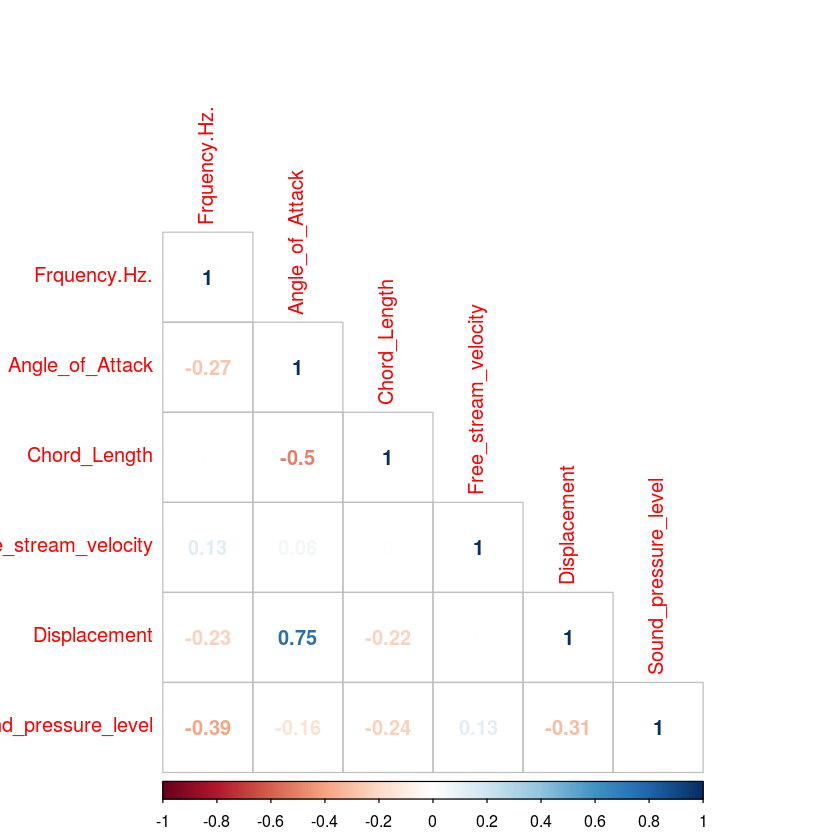

In [6]:
library(corrplot)
corrplot(cor(mydata), method='number', type = 'lower')

Here we see that Displacement and Angle of Attack have 75% correlation. We will leave this in for now.

Let's check for outliers in the data. Below i've taken boxplots together with similar ranges together. This is to ensure readability, we can plot each boxplot by itself too.

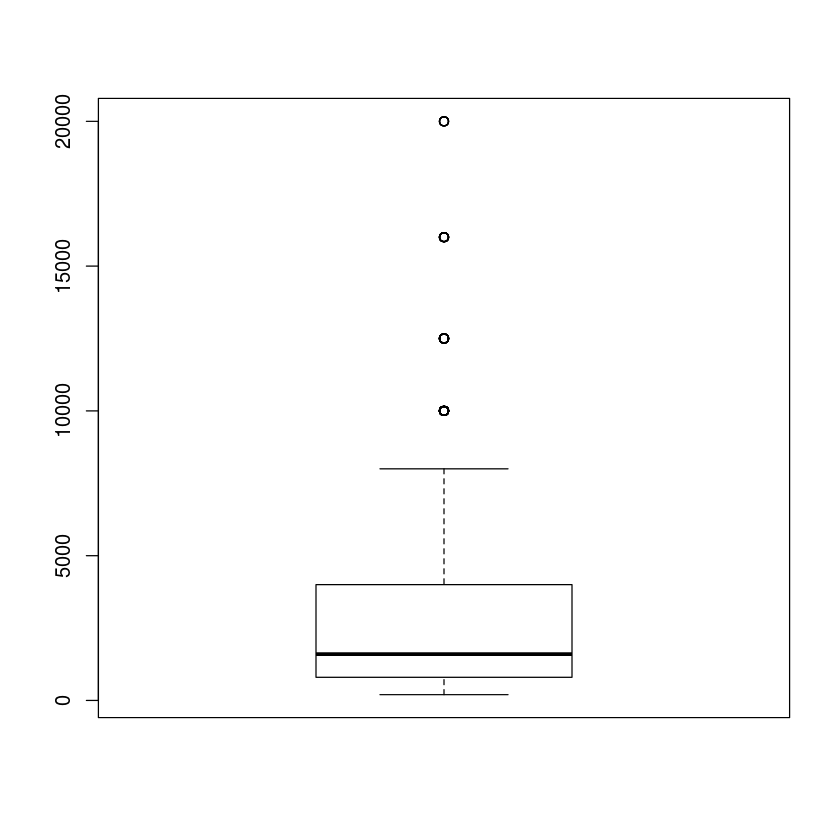

In [7]:
boxplot(mydata$Frquency.Hz.)

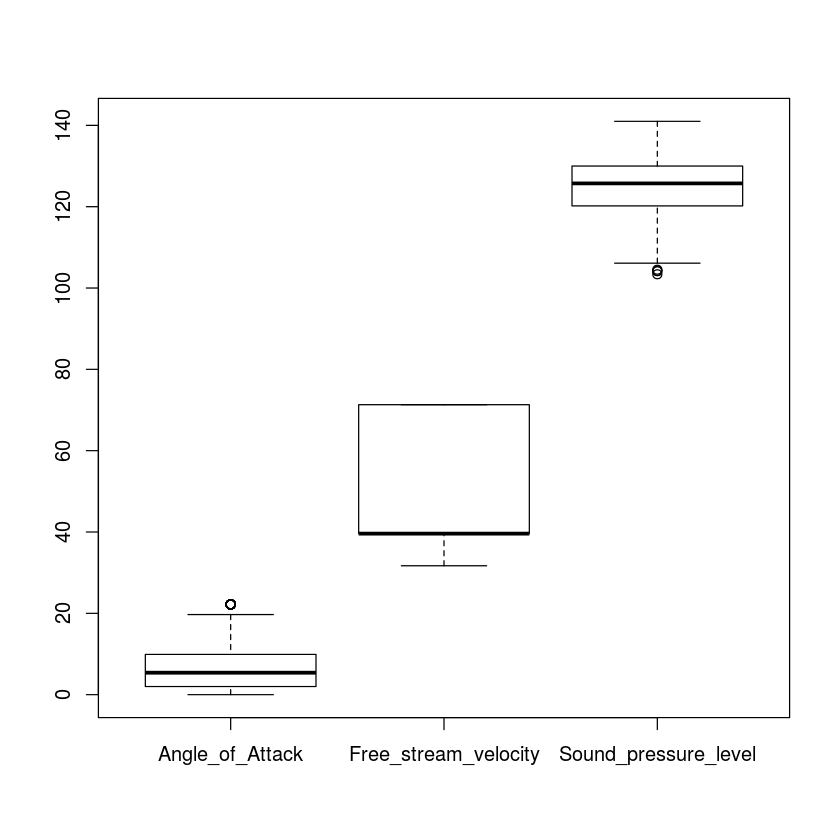

In [13]:
boxplot(mydata[,-c(1,3,5)])

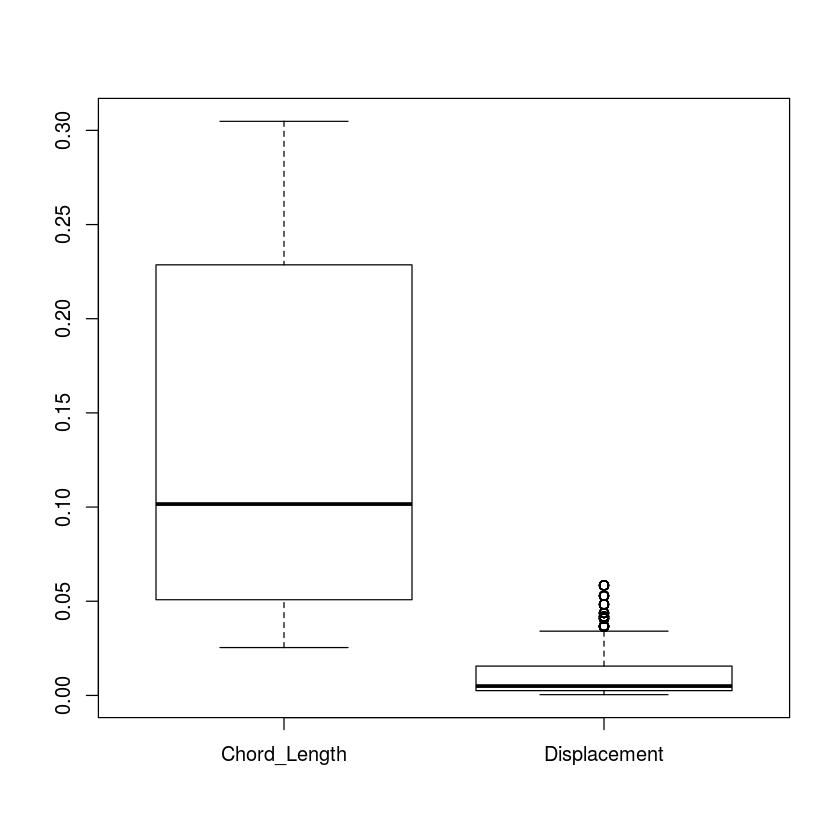

In [14]:
boxplot(mydata[,c(3,5)])

Freq: We have some outliers in the range of 10000, to 20000.

AOA, Free Stream Velocity and Sound Pressure Level seem to be fine.

Displacement seems to have some outliers. We will decide based on Cook's distance later on

We will go ahead and break up the data into train and test

In [17]:
set.seed(100)
sample_size <- floor(0.7*nrow(mydata))

In [18]:
#Just a simple automation to get 70% of overall data.
sample_size

[1] 1052

In [20]:
#This randomly selects row numbers from mydata. We will have 1052 rows
train_rows <- sample(seq_len(nrow(mydata)),size = sample_size)

In [24]:
length(train_rows)

[1] 1052

In [21]:
train_rows

[1]  463  388  830   85  703  725 1217  554  818  255  934 1317  419  594
  [15] 1136  996  305  532  534 1025  795 1054  798 1109  622  254 1138 1302
  [29]  810  410  720 1367  513 1403 1022 1306  265  923 1450  191  484 1265
  [43] 1137 1208  881  717 1461 1288  303  447  481  289  342  399  857  367
  [57]  179  333  864  306  670 1493 1385  975  641  515  655  640  352 1488
  [71]  591  470  820 1383  946  893 1223 1105 1189  131  654  853 1307 1396
  [85]   54 1431 1040  353  426 1038 1282  297  506  633 1278  549  729  177
  [99]   43 1084  460  547   58 1411  799  958 1357  980   17  747 1166 1124
 [113]  113 1446 1342   53 1272 1007  279 1163 1408  543  653  806  486   40
 [127] 1371 1318  759  141  327 1181 1013  682  794   23  646 1401 1410  860
 [141]  918  119  196 1236  167  990 1290   59   27  270  684 1253  187  229
 [155]  819 1100 1457 1061   26  939 1095  763  644  217  120  218   36  949
 [169] 1016 1144  583  556  780 1098 1055  434 1387  866  608  803  382 1336
 [183] 1220  891  246  459  163  143  392 1102 1304  574  266 1263  865  390
 [197]  156  784  157 1029  482 1246 1425 1071  416 1140 1039  793   94  546
 [211]  446  972  283  377 1376  814 1149  957  588   47  730  563  770 1218
 [225]  345  842   98   91  473  379  702  471 1075  789  507  380  483  888
 [239] 1198  977  278  904  838  890 1416  897  831   52   77  351 1274 1462
 [253]  488  465 1482 1058 1465  166  769  985  421 1125 1319 1244  935 1129
 [267]  400  107 1126 1179  828 1363  542  142 1257  899 1490  210 1233  322
 [281]  418  257   20 1470  686  829  908 1156  199  395  161  773  401  786
 [295] 1448   87  800  917  667  650 1023 1210 1143  741 1433 1170  587 1468
 [309]  716 1132  440 1047 1231 1199  548  735  718  933  658  911  479  604
 [323]  619 1172 1269 1174  926  607 1190 1300  311  204  469  630  287  439
 [337]  678  244 1442  744 1449  510  674  298  538 1361  711 1108  553  867
 [351]   24  197  737  190  408  215 1030  273 1128   25  123  280  825   38
 [365]  626  778 1451  442  832 1092  862  659  524  403 1328  233 1305 1168
 [379]  300  791 1289 1160  450  221  929 1175 1489 1439 1083 1498  372  369
 [393] 1048  424 1139  567  154 1311 1369  329  564  307  398 1303  883  572
 [407]  764  930  927  429  168  699  314 1012  170 1049    2 1245 1353  839
 [421]  967 1496 1475 1001  100  536  213 1070 1378  234  956  128  396  174
 [435] 1447 1297 1309 1017 1415  907   69 1224  521 1219  541  844  598  374
 [449]  696  253 1142 1294  776 1349  121  642  954  664  288 1112  700  945
 [463]  761 1286 1101  887   57  264 1268  373  290  402  359 1045 1141 1203
 [477]  774  620  609  597  245 1250 1066 1500 1388  503   55  966  643  274
 [491] 1010  364  376  334  106  585  336    4 1000  371 1120  745 1314 1130
 [505]  394 1193  771  209 1002  582  323 1034 1355 1183  960    1  105 1238
 [519]  308 1073  576  721  651  709  109  214 1484  937 1296   22  665  808
 [533]  785  817  182   92  435  581  834  821  672 1026 1252  846  822  812
 [547]  313  523 1273 1086 1152 1261 1397 1165  533 1133 1167  223 1006  453
 [561]  823  248  625  827  856 1209  811 1348  694 1258 1486 1033  693 1491
 [575]  441 1119  687 1079  595  391  739  569  230  627  320 1050  603 1364
 [589] 1201  889  321 1340  561  680  876  847  719 1291 1020  188   29  984
 [603]  139 1391  134  964  231  487 1335 1228 1375  262  492 1477  983 1259
 [617]  991  317 1372 1467 1157  683 1351  332 1014 1270  366  733  282 1088
 [631]  540  589  238 1492 1147 1009  205 1292  677  924   96  767  701 1089
 [645]  516   35  407  666  496  275  848  423  580  628  997  375  634  639
 [659]  951  310   67  173  995  849  519 1080  566  344  559  760  346 1072
 [673] 1091  387  203 1277    7 1159 1284  108 1392  978    8  815  535  593
 [687]  584 1161  874  550  689 1380  247  118  420  673 1200  281  268  675
 [701] 1031  558  724 1153  845 1373  269  528  695 1063 1106  740  727 1382
 [715] 1455  898 1216 1352    3  449   64 1122  781 1255  920   66 1370 1389

In [25]:
# Selecting rows with numbers in train_rows in train data set and the remaining are put into test
train <- mydata[train_rows,]
test <- mydata[-train_rows,]

In [26]:
#Check if all looks good
dim(train)
dim(test)

[1] 1052    6

[1] 451   6

Build the Regression Model!

Lets start with all variables. 

In [27]:
model1 <- lm(Sound_pressure_level~., data=train)

In [28]:
summary(model1)


Call:
lm(formula = Sound_pressure_level ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.6793  -2.9094  -0.1826   3.0412  15.7734 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.326e+02  6.568e-01 201.895  < 2e-16 ***
Frquency.Hz.         -1.304e-03  5.229e-05 -24.940  < 2e-16 ***
Angle_of_Attack      -3.975e-01  4.743e-02  -8.379  < 2e-16 ***
Chord_Length         -3.502e+01  1.989e+00 -17.612  < 2e-16 ***
Free_stream_velocity  1.006e-01  9.799e-03  10.269  < 2e-16 ***
Displacement         -1.505e+02  1.820e+01  -8.272 3.98e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.827 on 1046 degrees of freedom
Multiple R-squared:  0.5105,	Adjusted R-squared:  0.5082 
F-statistic: 218.2 on 5 and 1046 DF,  p-value: < 2.2e-16


Lucky us. All the Variables are significant. If not, we could have checked for stepwise AIC as below

In [31]:
model2 <- stepAIC(model1, data=train, direction = "both")

Start:  AIC=3318.35
Sound_pressure_level ~ Frquency.Hz. + Angle_of_Attack + Chord_Length + 
    Free_stream_velocity + Displacement

                       Df Sum of Sq   RSS    AIC
<none>                              24376 3318.3
- Displacement          1    1594.5 25971 3383.0
- Angle_of_Attack       1    1636.2 26012 3384.7
- Free_stream_velocity  1    2457.4 26834 3417.4
- Chord_Length          1    7228.2 31604 3589.5
- Frquency.Hz.          1   14495.3 38872 3807.3


This shows that the best model is when we keep all 5 variables in the model.

For some fun, we can also check forward / backward models

In [32]:
model3 <- step(model1,direction="backward")

Start:  AIC=3318.35
Sound_pressure_level ~ Frquency.Hz. + Angle_of_Attack + Chord_Length + 
    Free_stream_velocity + Displacement

                       Df Sum of Sq   RSS    AIC
<none>                              24376 3318.3
- Displacement          1    1594.5 25971 3383.0
- Angle_of_Attack       1    1636.2 26012 3384.7
- Free_stream_velocity  1    2457.4 26834 3417.4
- Chord_Length          1    7228.2 31604 3589.5
- Frquency.Hz.          1   14495.3 38872 3807.3


Again the same result as before. So we are on the right track. 

Finally, trying forward

In [34]:
model4 <- step(model1,scope = list(upper=model1,lower=~1),direction = "forward")

Start:  AIC=3318.35
Sound_pressure_level ~ Frquency.Hz. + Angle_of_Attack + Chord_Length + 
    Free_stream_velocity + Displacement



Same result again :) 

Now we are sure of the model, let us go ahead and interpret the results of the model.


In [35]:
summary(model1)


Call:
lm(formula = Sound_pressure_level ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.6793  -2.9094  -0.1826   3.0412  15.7734 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.326e+02  6.568e-01 201.895  < 2e-16 ***
Frquency.Hz.         -1.304e-03  5.229e-05 -24.940  < 2e-16 ***
Angle_of_Attack      -3.975e-01  4.743e-02  -8.379  < 2e-16 ***
Chord_Length         -3.502e+01  1.989e+00 -17.612  < 2e-16 ***
Free_stream_velocity  1.006e-01  9.799e-03  10.269  < 2e-16 ***
Displacement         -1.505e+02  1.820e+01  -8.272 3.98e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.827 on 1046 degrees of freedom
Multiple R-squared:  0.5105,	Adjusted R-squared:  0.5082 
F-statistic: 218.2 on 5 and 1046 DF,  p-value: < 2.2e-16


Firstly, all variables are significant [as p-value] is less that 0.05. Hence we can go ahead and continue checking the remainder of the summary. Here each p-value for each variable tests the null hypothesis that the variable has no correlation with the dependent variable. If it is less than 0.05 [assumed significane level in this case], we can reject the null hypotheses and hence claim that the particular variable is related and significant.

1 very important point to note. When we are trying to find the best model, we usually go into iterations of variable combinations to find which variables are significant. Just because a variable is not significant in 1 model iteration does not mean it would not be significant in other iterations. We have to run the model again and check all the p-values again. Some which were not significant could turn out to be significant and vice-versa.

We next check F-statistic [218.2]. This is a F-test which compares our present model to a model containing no explanatary variables [ hence comparing our model to a model which always predicts mean for the response/dependent variable] and tells us how good our model is. The higher this value, the better our model is. 

Also along with this check what the overall p-value is [2.2e-16]. Here this is very small, which goes against the overall H0 [null hypothesis] that the no-variable model and our model fits the data equally effectively. Hence we can say that the overall model is significant. Note this only says that the collective impact of our variables is different from the no-variable model. This does not talk about individual variables.

Next we look at the Estimates or coeffecients. This gives us the change in the value of the independent variable if there was a unit change in that particular dependent variable, keeping all other variables constant. 

Eg. Freq = -1.304 e-3. Hence keeping all other variables constant an increase in 1 unit of Freq results in Sound Pressure level decreasing [because of minus sign] by 1.304 e-3 units. Another example would be for every unit increase in Free Stream Velocity, keeping all other variables constant, Sound Pressure level would increase by 1.006 e-1 units.
Do note that interpreting the value for the intercept like this is not possible always and in most cases very tricky .

Std. Error gives the variability associated with the coeffecients. Hence it tells us the approximate error in estimating the coeffecient of the variable. Smaller the Std. Error for the variable, the more accurate the prediction for the variable is.

E.g. For Displacement, there will be an error of 18.32 while estimating the coeffecient. One thing to note that the size or scale of the coeffecient is to be taken into account when deciding if this is small or large. This brings us to our next point.... 

The coefficient t-value is a measure of how many standard deviations our coefficient estimate is far away from 0. We want it to be far away from zero as this would indicate we could reject the null hypothesis - that is, we  could declare a relationship between the variables exist. It is also the ratio of the coeffecient to the Std.Error. An absolute t-value greater than 2 is consdiered acceptable.

E.g Chord length - Coeffecient = -35.02. Std.Error = 1.989
t Value = -35.02/1.989 = -17.6068 Hence this directly gives you an idea if the error in the estimate is acceptable or not.

The Residual Standard Error of the model tells us how much , on an average the error will be when we make predictions about the dependent variable. It's units are the same as the dependent variable.

Multiple R-Squared is the ratio of the Variance Explained to the Total Variance in the model. It gives a percentage as to how much of the variance of the dependent variable is explained by the indepepndent variables. In this case 51% of the variance of the model is explained.

Adjusted R-Squared. This term is related to R-Sqaured. It is different in the sense that it penalises the R-Squared value with regards to the number of terms added in the model. 

This is because for R-Squared, the value would always increase if we added another variable in a model. Hence to check if adding the variable is actually beneficial , we use the Adjusted R-Squared to compare values and decide if the variable should be added.

Now that we have finished interpreting the model, we will check the relative importance of the variables

In [37]:
library(relaimpo)
relImp <- calc.relimp(model1, type = "lmg", rela = T)

In [38]:
relImp

Response variable: Sound_pressure_level 
Total response variance: 47.38095 
Analysis based on 1052 observations 

5 Regressors: 
Frquency.Hz. Angle_of_Attack Chord_Length Free_stream_velocity Displacement 
Proportion of variance explained by model: 51.05%
Metrics are normalized to sum to 100% (rela=TRUE). 

Relative importance metrics: 

                            lmg
Frquency.Hz.         0.43919266
Angle_of_Attack      0.09623623
Chord_Length         0.20742384
Free_stream_velocity 0.06267559
Displacement         0.19447168

Average coefficients for different model sizes: 

                                1X           2Xs           3Xs           4Xs
Frquency.Hz.         -8.906401e-04 -9.999904e-04 -1.115633e-03 -1.221433e-03
Angle_of_Attack      -1.890210e-01 -1.834555e-01 -2.058634e-01 -2.697267e-01
Chord_Length         -1.758892e+01 -2.253924e+01 -2.714433e+01 -3.129467e+01
Free_stream_velocity  6.172259e-02  6.784962e-02  7.537933e-02  8.595911e-02
Displacement         -1.705184e+

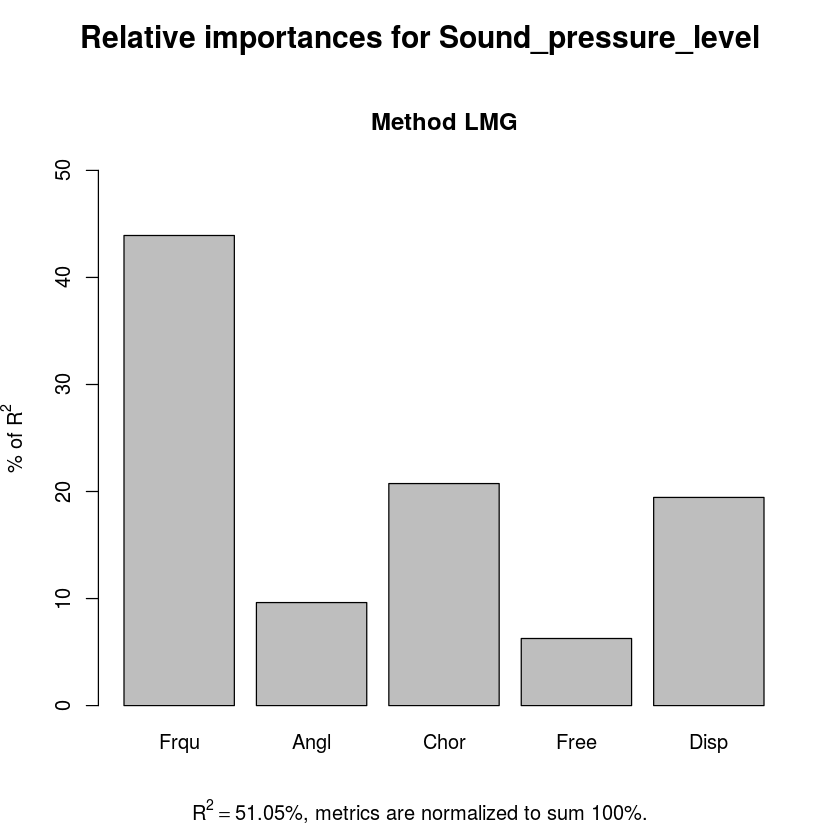

In [39]:
plot(relImp, ylim = c(0,50),)

Here we can see that Freq is the most important predictor, followed by Chord Length , Displacement, Angle of Attack and Free Stem Velocity.

Note that here, all the Variance numbers are given after normalizing the Variance explained to 100%.

Now, let's quickly go ahead and check for collinearity. Multi-collinearity occurs when independent variables are highly correlated amongst themselves. If we were to keep variables with high multi-collinearity, we would have inflated R-Squared values. 

We can check for this using the vif function

In [40]:
vif(model1)

Frquency.Hz.      Angle_of_Attack         Chord_Length 
            1.129425             3.403934             1.498073 
Free_stream_velocity         Displacement 
            1.041131             2.537398

Usually , a vif of less than 4 is considered acceptable. Hence we're good here. Anything more than 10 surely needs to be removed.

Linear regression is based on some assumptions. It is very important to check that our model fulfills the assumptions or the model will not work very well on test data.

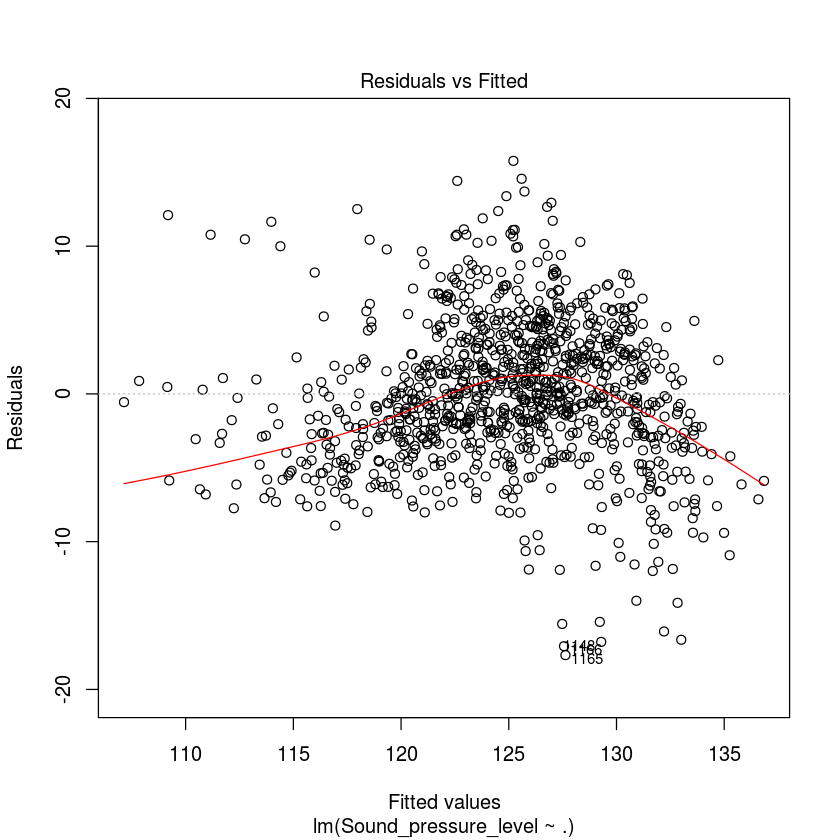

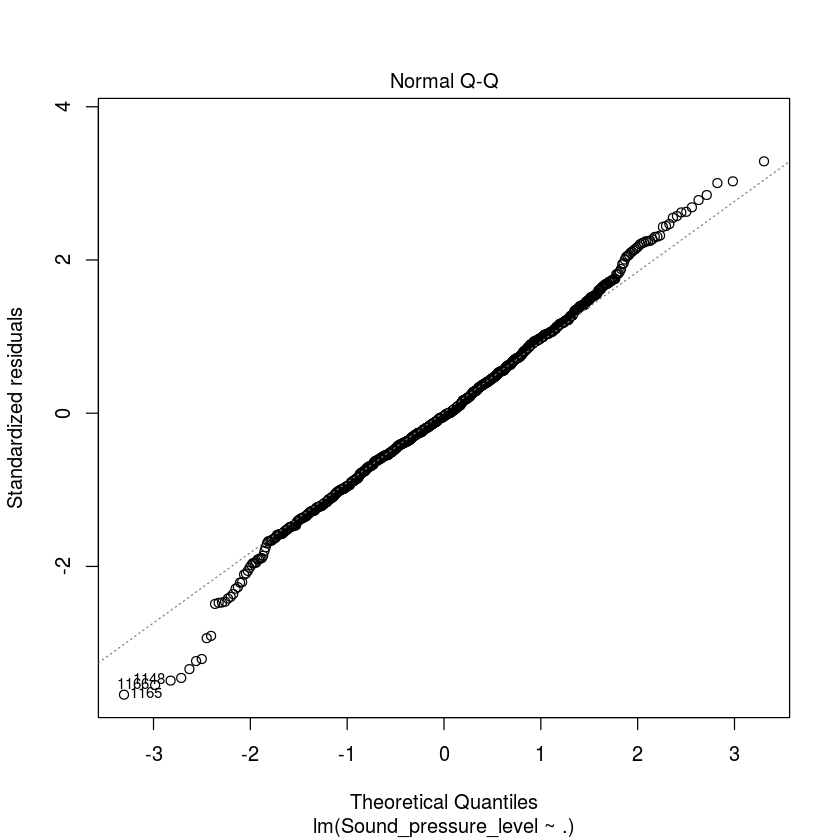

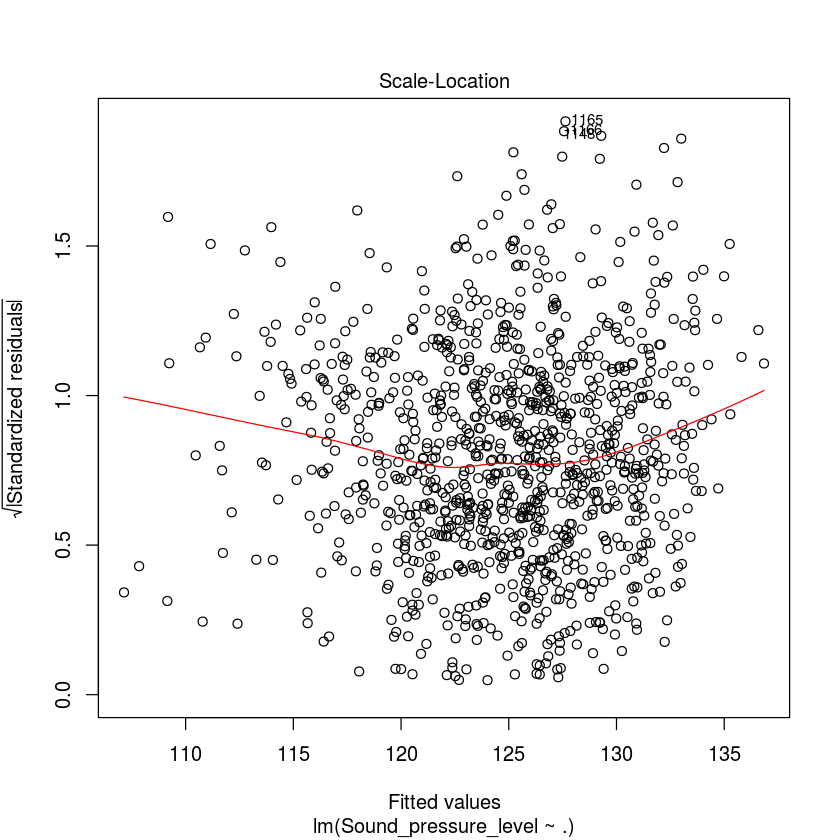

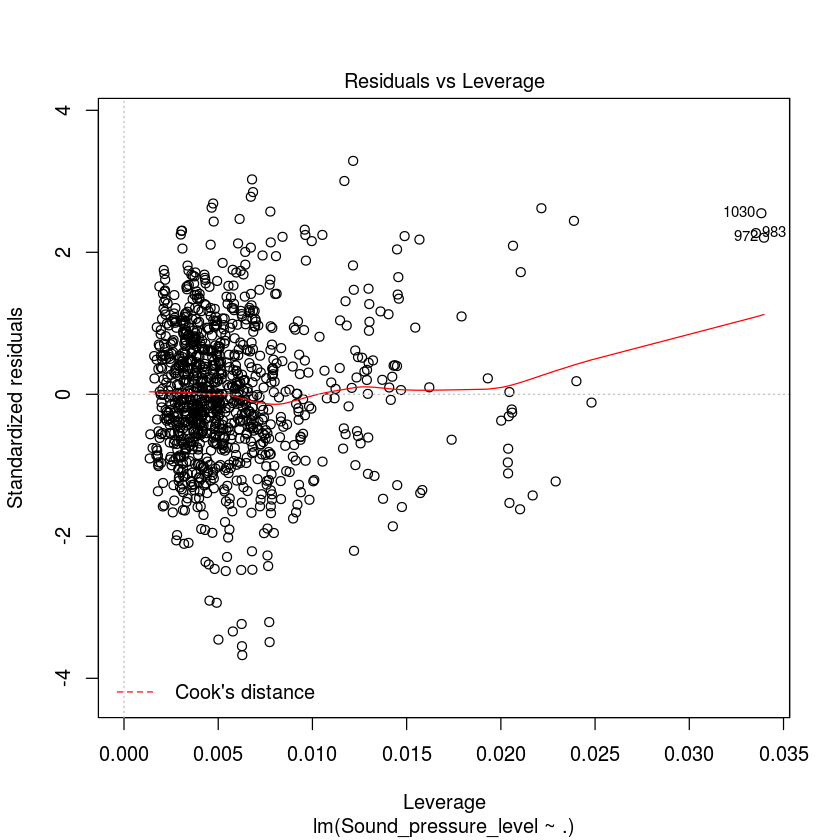

In [44]:
plot(model1)

Residual vs Fitted:

The residuals should be randomly distributed around 0 and there should not be any pattern. If there is any shape, it suggests non-linearity in the relationship. In addition, if it shows a funnel shape it suggests the data suffers from heteroskedasticity [ unequal variance of residuals]

Here we see some pattern, hence probably there exists a non-linear component in the relationship.

Normal Q-Q:

This plot displays residuals versus their expected values when the distribution is normal. We use this plot to verify that residuals are normally distributed. Ideally, this plot should show a straight line. If there is a curved, distorted line, then the residuals have a non-normal distribution. We woud then need to perform non-linear transformations of the variables to bring an improvement in the model.

Here we can see the lower part of the plot does not follow the line well. Case numbers for some extreme values are provided as well. We should note these down and then consider transforming the data or removing them from the data in case these are outliers.

Scale - Location Plot:

This plot shows if residuals are spread equally along the ranges of predictors. It is used to determine heteroskedasticity. This plot shouldn't show any funnel shape. Presence of a funnel pattern shows heteroskedasticity.

Here we can see that the line is slightly curved but no funnel shape. Hence residuals are not heteroskedastic

Residuals vs. Leverage

This plot helps us find out any influential cases in the data. Almost all data have outliers, but not all outliers are influential with respect to the linear regression line. Unlike the other plots, this time patterns are not relevant. We watch out for outlying values at the upper right corner or at the lower right corner. Those spots are the places where cases can be influential against a regression line. In our case, everything looks fine.


So what did we learn from our plots? It seems that there is some pattern - a non-linear relationship between the variables that is not being captured by the model yet. We should go and remedy that as it would also help us increase our predictive power when we run this aginst unseen data.

While plots are good to give a sense of what's going on, its always good to backup plots with proper tests. Let's test for Homoscedasticity!

Durbin Watson Test

This test is used to check autocorrelation.(a relationship between values
separated from each other by a given time lag).  Autocorrelation can lead to underestimates of the standard error and can cause you to think predictors are significant when they are not. 

Its value lies between 0 and 4. A DW=2 value shows no autocorrelation. However, a value between 0 < DW < 2 implies positive autocorrelation, while 2 < DW < 4 implies negative autocorrelation.

The Hypotheses for the Durbin Watson test are:
H0 = no first order autocorrelation.
H1 = first order correlation exists.


In [45]:
durbinWatsonTest(model1)

 lag Autocorrelation D-W Statistic p-value
   1     -0.03630718       2.07218    0.28
 Alternative hypothesis: rho != 0

Here D-W Statistic is 2.07, hence points towards no autocorrelation. Also p value is greater than 0.05, hence we do not reject the null hypothesis.

Breusch-Pagan / Cook Weisberg Test - 

This test is used to determine presence of heteroskedasticity. If you find p < 0.05, you reject the null hypothesis and infer that heteroskedasticity is present.


In [46]:
bptest(model1)


	studentized Breusch-Pagan test

data:  model1
BP = 62.975, df = 5, p-value = 2.946e-12


p-value is less than 0.05 ; hence we can reject the null hypothesis that the variance of the 
residuals is constant and infer that heteroscedasticity is indeed present, thereby confirming our graphical inference.

ncv Test

Computes a score test of the hypothesis of constant error variance against the alternative that the error variance changes with the level of the response (fitted values), or with a linear combination of predictors.

In [48]:
ncvTest(model1)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 4.30172    Df = 1     p = 0.03807384 

Once again, p-value is less than 0.05 ; hence we can reject the null hypothesis that the variance of the residuals is constant and infer that heteroscedasticity is indeed present, thereby confirming our graphical inference.

Hence we now know that

1) There exists a non-linear relationship. This needs to be incorporated in the model using interaction terms / quadratic terms etc.

2) Heteroscedasticity exists for the residuals. We'll need to address this by performing transformations on the variables [log , inverse, box-cox etc]